In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
import pickle
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)

eSOH_DIR = "./data/eSOH/"
oCV_DIR = "./data/ocv/"
cyc_DIR = "./data/cycling/"
fig_DIR = "./figures/"
res_DIR = "./results/"
%matplotlib widget

In [2]:
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        "lithium plating": "irreversible",
        "stress-induced diffusion": "false",
    }
)
parameter_values = get_parameter_values()
param=spm.param

# Capacity, Resistance and Expansion Trends from Data. Voltage and Expansion Simulations at BOL and EOL
# (Figure 1)

In [3]:
cell = 10
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
Ns = np.insert(N[1:]-1,0,0)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
pybamm.set_logging_level("WARNING")
parameter_values = get_parameter_values()
parameter_values.update(
    {
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "Positive electrode LAM constant proportional term [s-1]": 4.0312e-08,
        "Negative electrode LAM constant proportional term [s-1]": 1.8157e-07,
        "Positive electrode LAM constant proportional term 2 [s-1]": -1.4406e-09,
        "Negative electrode LAM constant proportional term 2 [s-1]": -4.9170e-09,
        "Positive electrode LAM constant exponential term": 1.0776,
        "Negative electrode LAM constant exponential term": 1.0776,
        "SEI kinetic rate constant [m.s-1]":  4.608e-16,
        "EC diffusivity [m2.s-1]": 4.56607447e-19,#8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.874e+04,
        "Lithium plating kinetic rate constant [m.s-1]": 2.3586e-09,
        "Initial inner SEI thickness [m]": 0e-09,
        "Initial outer SEI thickness [m]": 5e-09,
        "SEI resistivity [Ohm.m]": 30000.0,
        "Negative electrode partial molar volume [m3.mol-1]": 7e-06,
        "Negative electrode LAM min stress [Pa]": 0,
        "Negative electrode LAM max stress [Pa]": 0,
        "Positive electrode LAM min stress [Pa]": 0,
        "Positive electrode LAM max stress [Pa]": 0,
    },
    check_already_exists=False,
)
if cell == 13 or cell == 16:
    parameter_values.update(
        {
            "Negative electrode partial molar volume [m3.mol-1]":	0.747*7e-06,
        },
        check_already_exists=False,
    )
experiment = pybamm.Experiment(
        [
            ("Discharge at "+c_rate_d+dis_set,
            "Rest for 10 sec",
            "Charge at "+c_rate_c+" until 4.2V", 
            "Hold at 4.2V until C/100")
        ] *N[-1],
        termination="50% capacity",
    )

all_sumvars_dict = cycle_adaptive_simulation_V2(spm, parameter_values, experiment,SOC_0, save_at_cycles=1)
with open(res_DIR+'fast_sim_'+"cell_"+cell_no+'_sum_var.pickle', 'wb') as handle:
    pickle.dump(all_sumvars_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
for cyc_no in [0,len(N)-1]:
        t_d,V_d,I_d,Q_d,E_d = load_cycling_data(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
        t,I,Q,Vt,Exp,sol,rmse_V,rmse_E,rmse_VQ,rmse_EQ = cyc_comp_ch_dh(cyc_no,all_sumvars_dict,t_d,Q_d,V_d,E_d,parameter_values,spm,Ns,c_rate_c,c_rate_d)
        df = pd.DataFrame({'t': t,'I': I, 'Q': Q,'Vt':Vt,'Exp':Exp,
                        })
        df.to_csv(res_DIR + "volt_exp_sim_cell_"+cell_no+"_cyc_"+f"{N[cyc_no]}"+".csv", index=False)

CasADi - 2024-07-02 00:51:07 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:515]


findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Font family ['cursive'] not found. Fal

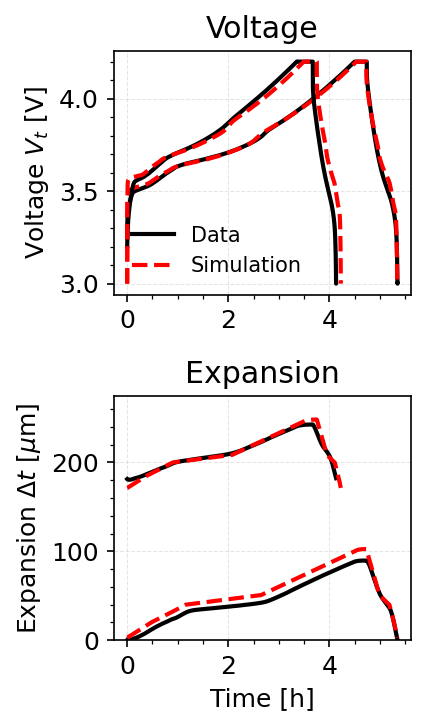

In [4]:
titles = ["BOL","MOL","EOL"]
linestyles = ["solid","dashed","dotted"]
b1 =544.61
b2 =11004.28
b3 =413.85
b4 =0.0
with open(res_DIR+'fast_sim'+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
    df = pickle.load(handle)
# del_sei = df["X-averaged SEI thickness [m]"]
# del_li = df["X-averaged lithium plating thickness [m]"]
# irrev_exp = (b1*del_sei*1e6+b2*del_li*1e6+b3*del_sei**2*1e12+b4*del_li**2*1e12)
del_sei = df["X-averaged SEI thickness [m]"]
del_li = df["X-averaged lithium plating thickness [m]"]
es_ic_n = -df["X-averaged negative electrode active material volume fraction"]+df["X-averaged negative electrode active material volume fraction"][0]
es_ic_p = -df["X-averaged positive electrode active material volume fraction"]+df["X-averaged positive electrode active material volume fraction"]
irrev_exp = (b1*del_sei*1e6+b2*del_li**2*1e12+b3*es_ic_n+b4*es_ic_p)
fig, ax = plt.subplots(2,1,figsize=(3,5))
for cyc_no in [0,len(N)-1]:
    t_d,V_d,I_d,Q_d,E_d = load_cycling_data(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
    df = pd.read_csv(res_DIR + "volt_exp_sim_cell_"+cell_no+"_cyc_"+f"{N[cyc_no]}"+".csv")
    ax1 = ax.flat[0]
    ax1.plot(t_d/3600,V_d,'k',linewidth=2)
    ax1.plot(df['t']/3600,df["Vt"],'r--',linewidth=2)
    # ax1.set_xlabel('Time [h]')
    ax1.set_ylabel('Voltage $V_t$ [V]')
    ax1.set_title('Voltage')
    # ax1.set_title('{} [N:{:0.0f},Ah:{:0.0f},%Cap:{:0.1f}]'.format(titles[i],N[cyc_no],dfe['Ah_th'][cyc_no],(dfe["Cap"][cyc_no]/dfe["Cap"][0])*100))
    ax1.legend(["Data",'Simulation'])
    ax3 = ax.flat[1]
    ax3.plot(t_d/3600,E_d+dfe["irrev_exp"][cyc_no],'k',linewidth=2)
    ax3.plot(df['t']/3600,df["Exp"]+irrev_exp[Ns[cyc_no]],'r--',linewidth=2)
    ax3.set_xlabel('Time [h]')
    ax3.set_ylim([0,275])
    ax3.set_ylabel('Expansion $\Delta t$ [$\mu$m]')
    ax3.set_title('Expansion')
fig.tight_layout()
plt.savefig(fig_DIR +'volt_exp_cell_10.png')

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

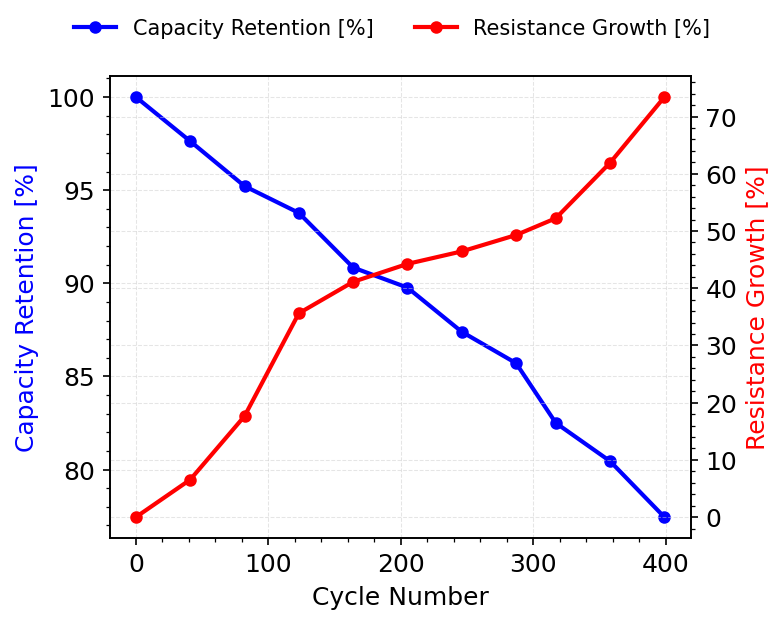

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

In [5]:
cell = 10
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
Ns = np.insert(N[1:]-1,0,0)
df = pd.read_csv(res_DIR + "DC_resistance_cell_"+cell_no+".csv")
cap_data = dfe["Cap"]/dfe["Cap"][0]*100
fig ,ax = plt.subplots(1,1, figsize=(5,4))
ax1 = ax
ax1.plot(dfe["N"],cap_data,"bo-")
ax1.set_xlabel("Cycle Number")
ax1.set_ylabel(r"Capacity Retention [%]",color="blue")
ax2 = ax1.twinx()
ax2.plot(df["N"],(df["Rs_data"]-df["Rs_data"][0])/df["Rs_data"][0]*100,"-o",color="red")
ax2.set_ylabel(r'Resistance Growth [%]',color="red")
fig.legend(["Capacity Retention [%]", 'Resistance Growth [%]'],loc="upper center",ncol=2)
plt.savefig(fig_DIR +'cap_resistance_exp_cell_'+cell_no+'.png')

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

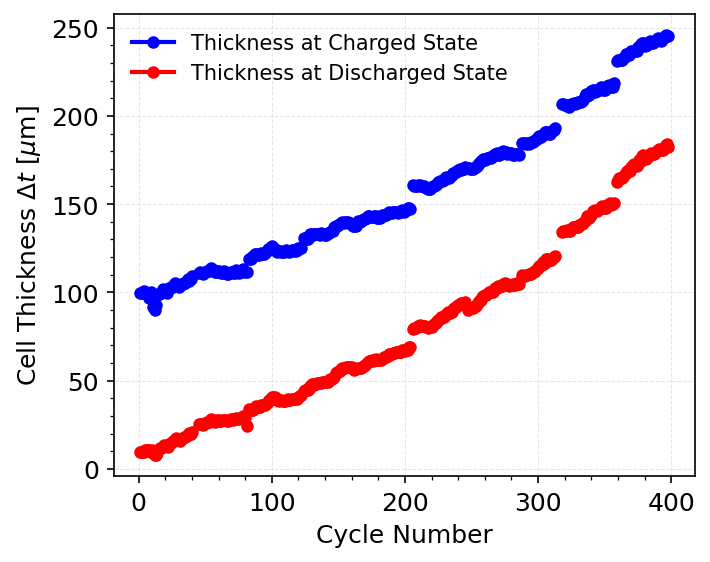

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

In [6]:
cyc_no = 0 
min_E = []
max_E = []
cyc_data_raw1 = pd.read_csv(cyc_DIR+'cycling_data_cell_'+cell_no+'.csv')
cyc_data_raw2 = cyc_data_raw1[ cyc_data_raw1['Cycle number'] == 41+cyc_no ]
E_c0 = cyc_data_raw2["Expansion [mu m]"]
E_c0 = E_c0.values
E_0 = 54.8 
for cyc_no in range(N[-1]):
    cyc_data_raw = cyc_data_raw1[ cyc_data_raw1['Cycle number'] == 41+cyc_no ]
    E_c1 = cyc_data_raw["Expansion [mu m]"]
    E_c1 = E_c1.values
    E_c1 = E_c1 - E_0
    min_E.append(min(E_c1))
    max_E.append(max(E_c1))
N_all = np.arange(0,N[-1])
fig ,ax = plt.subplots(1,1, figsize=(5,4))
ax1 = ax
ax1.plot(N_all,max_E,'b-o')
ax1.plot(N_all,min_E,'r-o')
ax1.set_xlabel('Cycle Number')
ax1.set_ylabel('Cell Thickness $\Delta t$ [$\mu$m]')
ax1.legend(["Thickness at Charged State", 'Thickness at Discharged State'])
plt.savefig(fig_DIR +'max_min_exp_cell_'+cell_no+'.png')

# Plot Li plating model variables (Figures 2 and 3)

In [8]:
cell = 1
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
Ns = np.insert(N[1:]-1,0,0)
parameter_values = get_parameter_values()
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
pybamm.set_logging_level("WARNING")
parameter_values = get_parameter_values()
parameter_values.update(
    {
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "Positive electrode LAM constant proportional term [s-1]": 4.0312e-08,
        "Negative electrode LAM constant proportional term [s-1]": 1.8157e-07,
        "Positive electrode LAM constant proportional term 2 [s-1]": -1.4406e-09,
        "Negative electrode LAM constant proportional term 2 [s-1]": -4.9170e-09,
        "Positive electrode LAM constant exponential term": 1.0776,
        "Negative electrode LAM constant exponential term": 1.0776,
        "SEI kinetic rate constant [m.s-1]":  4.608e-16,
        "EC diffusivity [m2.s-1]": 4.56607447e-19,#8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.874e+04,
        "Lithium plating kinetic rate constant [m.s-1]": 2.3586e-09,
        "Initial inner SEI thickness [m]": 0e-09,
        "Initial outer SEI thickness [m]": 5e-09,
        "SEI resistivity [Ohm.m]": 30000.0,
        "Negative electrode partial molar volume [m3.mol-1]": 7e-06,
        "Negative electrode LAM min stress [Pa]": 0,
        "Negative electrode LAM max stress [Pa]": 0,
        "Positive electrode LAM min stress [Pa]": 0,
        "Positive electrode LAM max stress [Pa]": 0,
    },
    check_already_exists=False,
)
if cell == 13 or cell == 16:
    parameter_values.update(
        {
            "Negative electrode partial molar volume [m3.mol-1]":	0.747*7e-06,
        },
        check_already_exists=False,
    )


c_rate_c ='C/5'
c_rate_d ='C/5'

experiment = pybamm.Experiment(
    [
        (
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50",
         "Rest for 5 min",
         "Discharge at "+c_rate_d+" until 3V",
        #  "Discharge at "+c_rate_d+" for 150 min",
         )
    ],
    termination="50% capacity",
    period = "10 sec",
#     cccv_handling="ode",
)
SOC_0 = 0.0
sim_long = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=SOC_0)
solution1 = sol_long

In [9]:
c_rate_c ='1.5C'
c_rate_d ='1.5C'

experiment = pybamm.Experiment(
    [
        (
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50",
         "Rest for 5 min",
         "Discharge at "+c_rate_d+" until 3V",
         )
    ],
    termination="50% capacity",
    period = "1 sec",
)

sim_long = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=SOC_0)
solution2 = sol_long

In [10]:
def plot_vars(solution):
    t =  solution["Time [s]"].entries
    t = t/3600
    V =  solution["Terminal voltage [V]"].entries
    I =  solution["Current [A]"].entries
    Q = -solution['Discharge capacity [A.h]'].entries
    Q_Li = solution["Loss of capacity to lithium plating [A.h]"].entries
    I_Li = solution["X-averaged lithium plating interfacial current density [A.m-2]"].entries

    I_de = solution["X-averaged negative electrode interfacial current density [A.m-2]"].entries
    I_st = solution["X-averaged lithium plating interfacial current density"].entries
    I_to = solution["X-averaged negative electrode total interfacial current density [A.m-2]"].entries

    # phi_seif = solution["X-averaged SEI film overpotential [V]"].entries
    phi_seif = []
    # phi_sei  = solution["X-averaged negative electrode sei reaction overpotential [V]"].entries
    phi_sei  = []
    # phi_sei = 0
    phi_pl  = solution["X-averaged negative electrode lithium plating reaction overpotential [V]"].entries
    phi_pl_nd  = solution["X-averaged negative electrode lithium plating reaction overpotential"].entries
    phi_del = solution["X-averaged negative electrode surface potential difference [V]"].entries

    phi_ocp = solution["X-averaged negative electrode open circuit potential [V]"].entries
    phi_int = solution["X-averaged negative electrode reaction overpotential [V]"].entries

    i0_int = solution["X-averaged negative electrode exchange current density [A.m-2]"].entries
    phi_e_avg = solution["X-averaged negative electrolyte potential [V]"].entries
    c_e_avg = solution["X-averaged negative electrolyte concentration [mol.m-3]"].entries
    c_ss_n = solution["X-averaged negative particle surface concentration"].entries
    c_save_n1 = solution["R-averaged negative particle concentration"].entries
    c_save_n = c_save_n1[1,:]
    c_s_n = solution["X-averaged negative particle concentration"].entries

    u_css_n = solution["X-averaged negative electrode open circuit potential [V]"].entries

    # j_pl = solution["Negative electrode lithium plating interfacial current density [A.m-2]"].entries
    j_pl = []
    # eta_pl = solution["Negative electrode lithium plating reaction overpotential [V]"].entries
    eta_pl = []
    sigma_ts_n = solution["X-averaged negative particle surface tangential stress [Pa]"].entries
    sigma_rs_n = solution["X-averaged negative particle surface radial stress [Pa]"].entries
    sigma_hs_n = (sigma_rs_n+2*sigma_ts_n)/2
    sigma_ts_p = solution["X-averaged positive particle surface tangential stress [Pa]"].entries
    sigma_rs_p = solution["X-averaged positive particle surface radial stress [Pa]"].entries
    sigma_hs_p = (sigma_rs_p+2*sigma_ts_p)/2
    # sigma_ts_n = []
    # sigma_rs_n = []
    # sigma_hs_n = []
    # sigma_ts_p = []
    # sigma_rs_p = []
    # sigma_hs_p = []

    C_n = solution["Negative electrode capacity [A.h]"].entries
    C_p = solution["Positive electrode capacity [A.h]"].entries

    return t,V,I,Q,Q_Li,I_Li,I_de,I_st,I_to,phi_seif,phi_sei,phi_pl,phi_del,phi_ocp,phi_int,i0_int,phi_e_avg,c_e_avg,c_ss_n,c_save_n,c_s_n,u_css_n,j_pl,eta_pl,sigma_hs_n,C_n,sigma_hs_p,C_p

In [11]:
t1,V1,I1,Q1,Q_Li1,I_Li1,I_de1,I_st1,I_to1,phi_seif1,phi_sei1,phi_pl1,phi_del1,phi_ocp1,phi_int1,i0_int1,phi_e_avg1,c_e_avg1,c_ss_n1,c_save_n1,c_s_n1,u_css_n1,j_pl1,eta_pl1,sigma_hs_n1,C_n1,sigma_hs_p1,C_p1 = plot_vars(solution1)
t2,V2,I2,Q2,Q_Li2,I_Li2,I_de2,I_st2,I_to2,phi_seif2,phi_sei2,phi_pl2,phi_del2,phi_ocp2,phi_int2,i0_int2,phi_e_avg2,c_e_avg2,c_ss_n2,c_save_n2,c_s_n2,u_css_n2,j_pl2,eta_pl2,sigma_hs_n2,C_n2,sigma_hs_p2,C_p2 = plot_vars(solution2)

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found becau

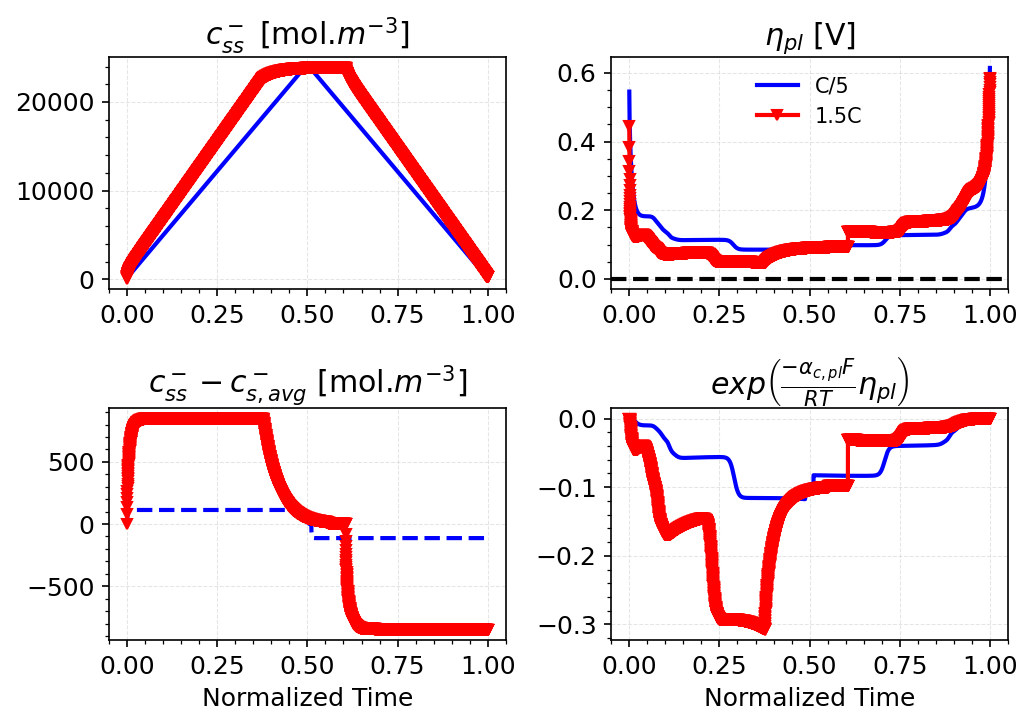

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

In [12]:
csmax_n = 28746
F = 96485
R = 8.314
T = 273.15+25
alpha_pl = 0.65
fig, axes = plt.subplots(2, 2, figsize=(7, 5))
ax2 = axes.flat[1]
ax2.plot(t1/t1[-1],phi_pl1,'b')
ax2.plot(t2/t2[-1],phi_pl2,'rv-')
ax2.axhline(y = 0.0, color = 'k', linestyle = '--')
ax2.set_title(r'$\eta_{pl}$ [V]')
ax4 = axes.flat[3]
ax4.plot(t1/t1[-1],-np.exp(-alpha_pl*F/R/T*phi_pl1),'b')
ax4.plot(t2/t2[-1],-np.exp(-alpha_pl*F/R/T*phi_pl2),'rv-')
ax4.set_title(r'$exp\left(\frac{-\alpha_{c,pl}F}{RT}\eta_{pl}\right)$')
ax1 = axes.flat[0]
# ax1.plot(t1,c_save_n1*csmax_n,'b--')
# ax1.plot(t2,c_save_n2*csmax_n,'r--')
ax1.plot(t1/t1[-1],c_ss_n1*csmax_n,'b')
ax1.plot(t2/t2[-1],c_ss_n2*csmax_n,'rv-')
ax1.set_title(r'$c_{ss}^-$ [mol.$m^{-3}$]')
ax3 = axes.flat[2]
ax3.plot(t1/t1[-1],(c_ss_n1-c_save_n1)*csmax_n,'b--')
ax3.plot(t2/t2[-1],(c_ss_n2-c_save_n2)*csmax_n,'rv-')
ax3.set_title(r'$c_{ss}^--c_{s,avg}^-$ [mol.$m^{-3}$]')
ax3.set_xlabel("Normalized Time")
ax4.set_xlabel("Normalized Time")
ax2.legend(['C/5','1.5C'])
fig.tight_layout()
plt.savefig(fig_DIR+'plating_compare_crate_1'+'.png')

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

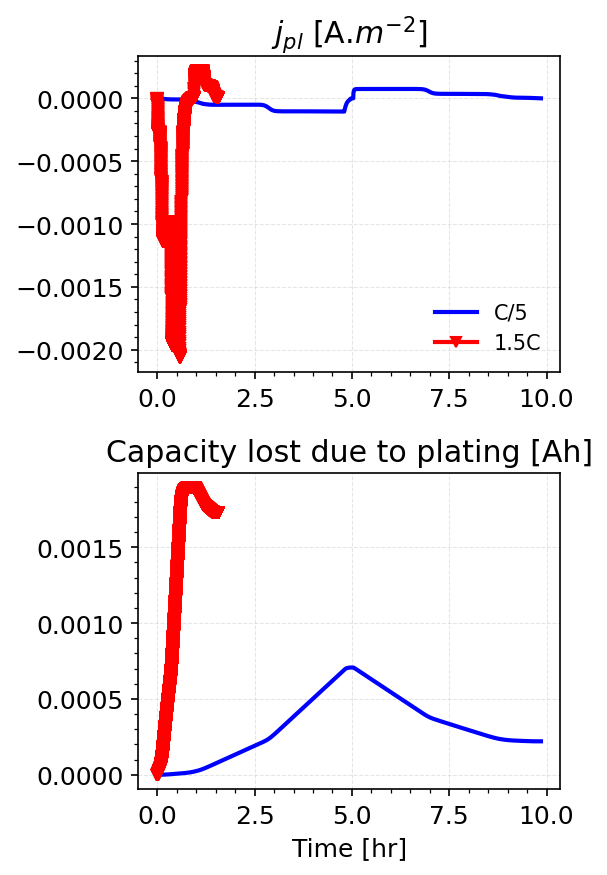

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(4, 6))
ax1=axes.flat[0]
ax1.plot(t1,I_Li1,'b')
ax1.plot(t2,I_Li2,'rv-')
ax1.set_title(r'$j_{pl}$ [A.$m^{-2}$]')
ax2 = axes.flat[1]
ax2.plot(t1,Q_Li1,'b')
ax2.plot(t2,Q_Li2,'rv-')
ax2.set_title('Capacity lost due to plating [Ah]')
ax2.set_xlabel("Time [hr]")
ax1.legend(['C/5','1.5C'])
fig.tight_layout()
plt.savefig(fig_DIR+'plating_compare_crate_2_1'+'.png')

# Concentration Dependent Stress (Figure 4)

In [14]:
def graphite_volume_change(sto):
    stoichpoints = np.array([0,0.12,0.18,0.24,0.50,1])
    thicknesspoints = np.array([0,2.406/100,3.3568/100,4.3668/100,5.583/100,13.0635/100])
    x = [sto]
    t_change = np.interp(x,stoichpoints,thicknesspoints)
    return t_change

In [15]:
def graphite_volume_change_rate(sto):
    stoichpoints = np.array([0,0.12,0.18,0.24,0.50,1])
    thicknesspoints = np.array([0,2.406/100,3.3568/100,4.3668/100,5.583/100,13.0635/100])
    i = 0
    if sto>=stoichpoints[i] and sto<stoichpoints[i+1]:
        t_change = (thicknesspoints[i+1]-thicknesspoints[i])/(stoichpoints[i+1]-stoichpoints[i])
    i = 1
    if sto>=stoichpoints[i] and sto<stoichpoints[i+1]:
        t_change = (thicknesspoints[i+1]-thicknesspoints[i])/(stoichpoints[i+1]-stoichpoints[i])
    i = 2
    if sto>=stoichpoints[i] and sto<stoichpoints[i+1]:
        t_change = (thicknesspoints[i+1]-thicknesspoints[i])/(stoichpoints[i+1]-stoichpoints[i])
    i = 3
    if sto>=stoichpoints[i] and sto<stoichpoints[i+1]:
        t_change = (thicknesspoints[i+1]-thicknesspoints[i])/(stoichpoints[i+1]-stoichpoints[i])
    i = 4
    if sto>=stoichpoints[i] and sto<=stoichpoints[i+1]:
        t_change = (thicknesspoints[i+1]-thicknesspoints[i])/(stoichpoints[i+1]-stoichpoints[i])

    return t_change

In [17]:
c_rate_c ='C/5'
c_rate_d ='C/5'
experiment = pybamm.Experiment(
    [
        (
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50",
         "Rest for 5 min",
         "Discharge at "+c_rate_d+" for 150 min",
         )
    ],
    termination="50% capacity",
    period = "10 sec",
)
SOC_0 = 0.5
sim_long = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=SOC_0)
solution3 = sol_long

In [18]:
t3,V3,I3,Q3,Q_Li3,I_Li3,I_de3,I_st3,I_to3,phi_seif3,phi_sei3,phi_pl3,phi_del3,phi_ocp3,phi_int3,i0_int3,phi_e_avg3,c_e_avg3,c_ss_n3,c_save_n3,c_s_n3,u_css_n3,j_pl3,eta_pl3,sigma_hs_n3,C_n3,sigma_hs_p3,C_p3 = plot_vars(solution3)

In [19]:
E_n = 15e9
nu_n = 0.2
O_n = 7e-6
c_s_max_n = 28746.0
CC = 2*E_n/(1-nu_n)/3*O_n/0.130635*c_s_max_n
Rn = 1e-5
Rvec = np.linspace(0,Rn,20)

In [20]:
def sigma_hfun(c_s1,c_save_n1):
    sigma_h = []
    sigma_h1 = []
    for nn in range(np.size(c_s1,1)):
        c_s = c_s1[:,nn]
        y_s = np.vectorize(graphite_volume_change)(c_s)
        y_s1 = np.vectorize(graphite_volume_change)(c_save_n1[nn])
        cube = Rvec[1:]**3-Rvec[:-1]**3
        muln = (y_s[1:]+y_s[:-1])/2
        sigma_h_s = CC*((1/Rn**3)*1/3*np.sum(cube*muln)-1/3*y_s[-1])
        sigma_h_s1 = CC*(1/3*y_s1-1/3*y_s[-1])[0]
        sigma_h.append(sigma_h_s)
        sigma_h1.append(sigma_h_s1)
    sigma_h = np.array(sigma_h)
    sigma_h1 = np.array(sigma_h1)
    return sigma_h,sigma_h1

In [21]:
sigma_h1,sigma_h1_1 = sigma_hfun(c_s_n1,c_save_n1)
sigma_h3,sigma_h1_3 = sigma_hfun(c_s_n3,c_save_n3)

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

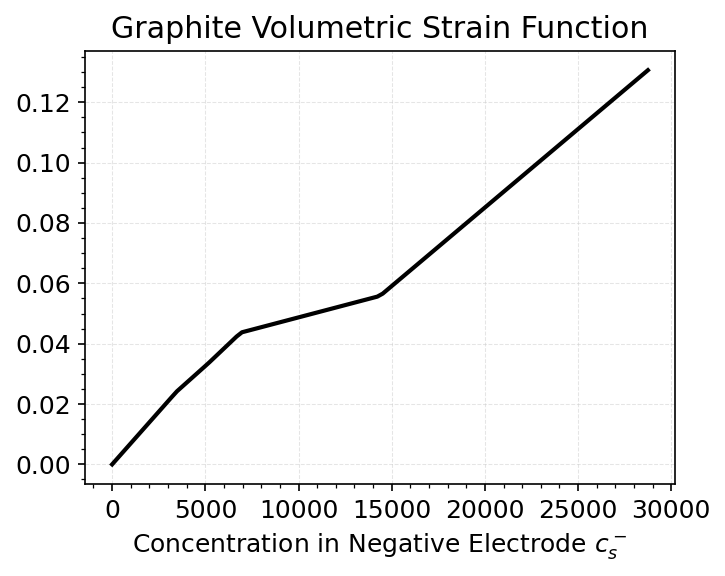

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

In [22]:
sto = np.linspace(0,csmax_n,100)
yout = np.zeros(len(sto))
for i in range(len(sto)):
    yout[i] = graphite_volume_change(sto[i]/csmax_n)
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(sto,yout,'k')
ax.set_xlabel(r'Concentration in Negative Electrode $c^-_{s}$')
# ax.set_ylabel(r'$\Delta\mathit{V}$')
ax.set_title("Graphite Volumetric Strain Function")
fig.tight_layout()
plt.show()
plt.savefig(fig_DIR+'graphtite_vol_strain'+'.png')

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

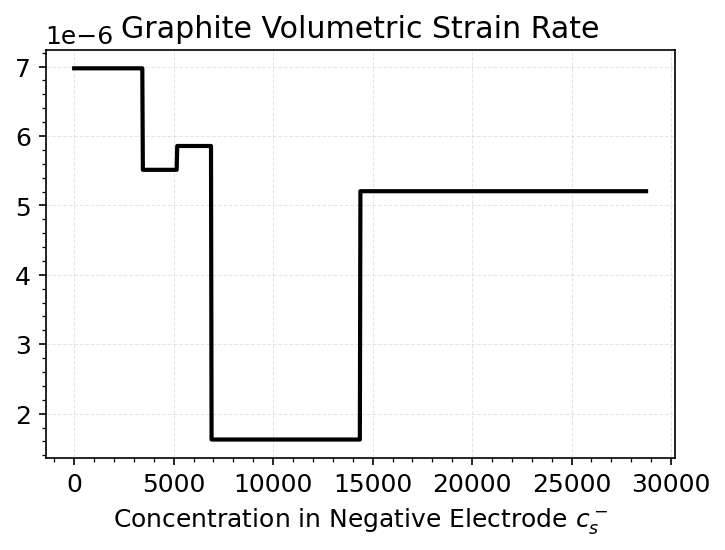

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

In [23]:
cs_max_n = 28746.0
sto = np.linspace(0,cs_max_n,1000)
yout = np.zeros(len(sto))
for i in range(len(sto)):
    yout[i] = graphite_volume_change_rate(sto[i]/cs_max_n)
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(sto,yout/cs_max_n,'k')
ax.set_xlabel(r'Concentration in Negative Electrode $c^-_{s}$')
# ax.set_ylabel(r'$\Delta\mathit{V}$')
ax.set_title("Graphite Volumetric Strain Rate")
fig.tight_layout()
plt.show()
plt.savefig(fig_DIR+'graphtite_vol_strain_rate'+'.png')

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

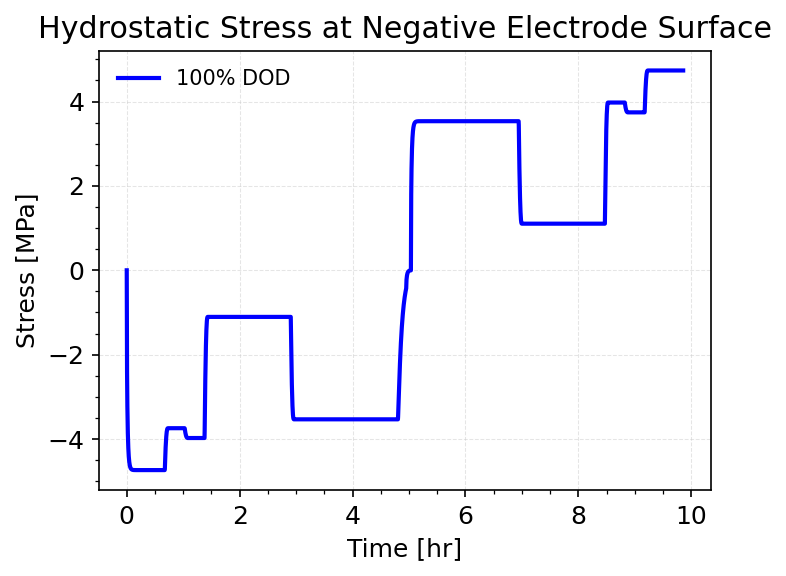

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

In [24]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
ax1 = ax
ax1.plot(t1,sigma_h1/1e6,'b')
ax1.legend(["100% DOD"])
ax1.set_title("Hydrostatic Stress at Negative Electrode Surface")
ax1.set_xlabel("Time [hr]")
ax1.set_ylabel("Stress [MPa]")
fig.tight_layout()
plt.savefig(fig_DIR+'conc_dep_stress_C5_100'+'.png')

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

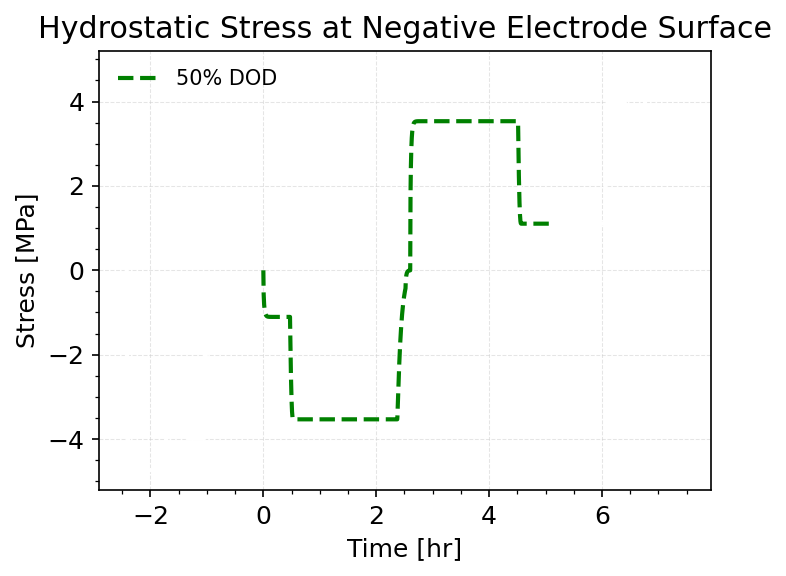

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

In [25]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
ax1 = ax
ax1.plot(t1-2.42,sigma_h1/1e6,'w',label='_nolegend_')
ax1.plot(t3,sigma_h3/1e6,'g--')

# ax1.plot(t1,sigma_h1_1,'b--')
ax1.legend(["100% DOD","50% DOD"])
ax1.set_title("Hydrostatic Stress at Negative Electrode Surface")
ax1.set_xlabel("Time [hr]")
ax1.set_ylabel("Stress [MPa]")
ax1.legend(["50% DOD"])
fig.tight_layout()
plt.savefig(fig_DIR+'conc_dep_stress_C5_50'+'.png')

# Current Densities Fresh vs Aged (Figure 5)

In [26]:
cell = 4
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
Ns = np.insert(N[1:]-1,0,0)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
pybamm.set_logging_level("WARNING")
parameter_values = get_parameter_values()
parameter_values.update(
    {
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "Positive electrode LAM constant proportional term [s-1]": 4.0312e-08,
        "Negative electrode LAM constant proportional term [s-1]": 1.8157e-07,
        "Positive electrode LAM constant proportional term 2 [s-1]": -1.4406e-09,
        "Negative electrode LAM constant proportional term 2 [s-1]": -4.9170e-09,
        "Positive electrode LAM constant exponential term": 1.0776,
        "Negative electrode LAM constant exponential term": 1.0776,
        "SEI kinetic rate constant [m.s-1]":  4.608e-16,
        "EC diffusivity [m2.s-1]": 4.56607447e-19,#8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.874e+04,
        "Lithium plating kinetic rate constant [m.s-1]": 2.3586e-09,
        "Initial inner SEI thickness [m]": 0e-09,
        "Initial outer SEI thickness [m]": 5e-09,
        "SEI resistivity [Ohm.m]": 30000.0,
        "Negative electrode partial molar volume [m3.mol-1]": 7e-06,
        "Negative electrode LAM min stress [Pa]": 0,
        "Negative electrode LAM max stress [Pa]": 0,
        "Positive electrode LAM min stress [Pa]": 0,
        "Positive electrode LAM max stress [Pa]": 0,
    },
    check_already_exists=False,
)
if cell == 13 or cell == 16:
    parameter_values.update(
        {
            "Negative electrode partial molar volume [m3.mol-1]":	0.747*7e-06,
        },
        check_already_exists=False,
    )
experiment = pybamm.Experiment(
        [
            ("Discharge at "+c_rate_d+dis_set,
            "Rest for 10 sec",
            "Charge at "+c_rate_c+" until 4.2V", 
            "Hold at 4.2V until C/100")
        ] *N[-1],
        termination="50% capacity",
    )

all_sumvars_dict = cycle_adaptive_simulation_V2(spm, parameter_values, experiment,SOC_0, save_at_cycles=1)

In [27]:
t1,I1,Q1,Vt1,Exp1,sol1 = cyc_comp_dh_ch(0,all_sumvars_dict,parameter_values,spm,Ns,c_rate_c,c_rate_d)
t2,I2,Q2,Vt2,Exp2,sol2 = cyc_comp_dh_ch(len(N)-1,all_sumvars_dict,parameter_values,spm,Ns,c_rate_c,c_rate_d)
I_Li1 = sol1["X-averaged lithium plating interfacial current density [A.m-2]"].entries
I_de1 = sol1["X-averaged negative electrode interfacial current density [A.m-2]"].entries
I_sei1 = sol1["X-averaged SEI interfacial current density [A.m-2]"].entries

I_Li2 = sol2["X-averaged lithium plating interfacial current density [A.m-2]"].entries
I_de2 = sol2["X-averaged negative electrode interfacial current density [A.m-2]"].entries
I_sei2 = sol2["X-averaged SEI interfacial current density [A.m-2]"].entries

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

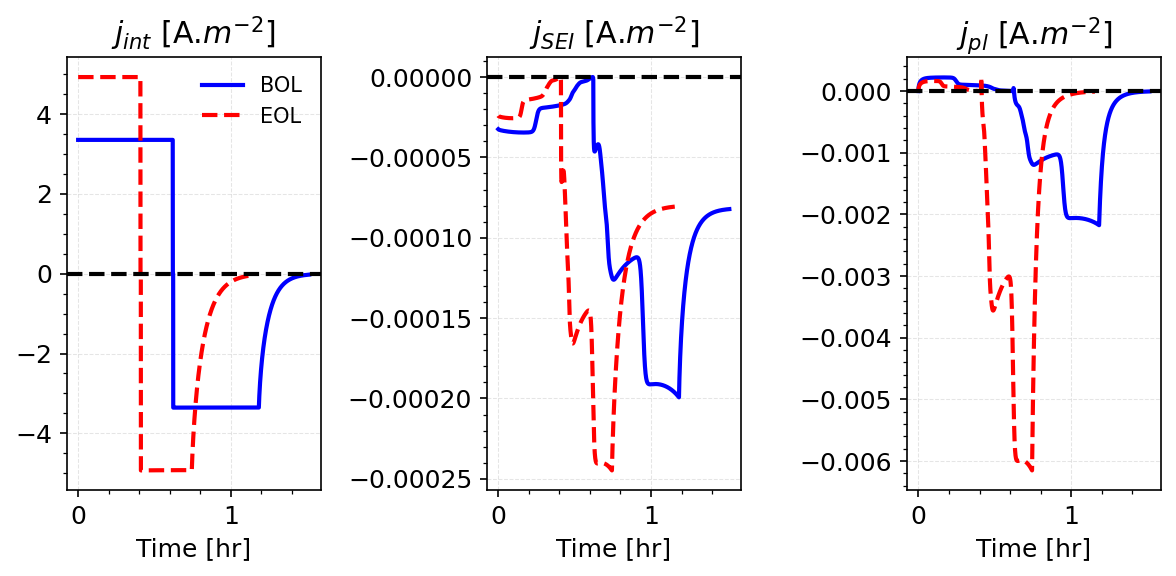

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(8, 4))
ax1 = axes.flat[0]
ax1.plot(t1/3600,I_de1,'b')
ax1.plot(t2/3600,I_de2,'r--')
ax1.legend(["BOL", "EOL"])
ax1.axhline(y = 0.0, color = 'k', linestyle = '--')
ax1.set_title(r'$j_{int}$ [A.$m^{-2}$]')
ax2=axes.flat[1]
ax2.plot(t1/3600,I_sei1,'b')
ax2.plot(t2/3600,I_sei2,'r--')
ax2.set_title(r'$j_{SEI}$ [A.$m^{-2}$]')
ax2.axhline(y = 0.0, color = 'k', linestyle = '--')
ax3 = axes.flat[2]
ax3.plot(t1/3600,I_Li1,'b')
ax3.plot(t2/3600,I_Li2,'r--')
ax3.axhline(y = 0.0, color = 'k', linestyle = '--')
ax3.set_title(r'$j_{pl}$ [A.$m^{-2}$]')
ax1.set_xlabel("Time [hr]")
ax2.set_xlabel("Time [hr]")
ax3.set_xlabel("Time [hr]")
# fig.suptitle("1.5C Fresh Cell")
fig.tight_layout()
plt.savefig(fig_DIR+'compare_currents_fresh_aged'+'.png')

# Voltage Components (Figure 6)

In [29]:
t_in0 = 10
t_in1 = 10
t_inf = t_in0+t_in1
t_in = np.arange(0,t_inf,0.1)
# t_in = np.arange(0,t_inf,1)
# t_sim = np.arange(0,t_inf,0.01)
I_in = []
for tt in t_in:
    if tt<t_in0:
        I_in = np.append(I_in,0)
    elif tt>=t_in0 and tt<t_in0+t_in1:
        I_in = np.append(I_in,5)
# I_in = np.array([0,0,5,5,0,0,-5,-5,0,0])
timescale = parameter_values.evaluate(spm.timescale)

In [30]:
SOC = 0.5
cyc_no = 0
# cyc_no = len(N)-1
eSOH = all_sumvars_dict
model = spm
Vmin = 3.0
Vmax = 4.2
esoh_model = pybamm.lithium_ion.ElectrodeSOH()
esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
Cn = eSOH["C_n"][Ns[cyc_no]]
    # print(Cn)
Cp = eSOH["C_p"][Ns[cyc_no]]
c_n_max = parameter_values.evaluate(param.n.prim.c_max)
c_p_max = parameter_values.evaluate(param.p.prim.c_max)
n_Li_init = eSOH["Total lithium in particles [mol]"][Ns[cyc_no]]
eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))
del_sei = eSOH['X-averaged SEI thickness [m]'][Ns[cyc_no]]
c_lip = eSOH['X-averaged lithium plating concentration [mol.m-3]'][Ns[cyc_no]]
n_Li_init = eSOH["Total lithium in particles [mol]"][Ns[cyc_no]]
esoh_sol = esoh_sim.solve(
    [0],
    inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
    solver=pybamm.AlgebraicSolver(),
)
parameter_values.update(
        {
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+25,
            "Ambient temperature [K]": 273.15+25,
            "Initial inner SEI thickness [m]": 0e-09,
            "Initial outer SEI thickness [m]": del_sei,
            "Initial plated lithium concentration [mol.m-3]": c_lip,
        }
    )
timescale = parameter_values.evaluate(spm.timescale)
current_interpolant = pybamm.Interpolant(
t_in, -I_in, timescale * pybamm.t
)
parameter_values["Current function [A]"] = current_interpolant
SOC_vals = np.linspace(1,0,11)
Rs_ch_s = []

c_n_max = parameter_values.evaluate(param.n.prim.c_max)
c_p_max = parameter_values.evaluate(param.p.prim.c_max)
x_100 = esoh_sol["x_100"].data[0]
y_100 = esoh_sol["y_100"].data[0]
x_0 = esoh_sol["x_0"].data[0]
y_0 = esoh_sol["y_0"].data[0]
cs_n_0 = (SOC*(x_100-x_0)+x_0)*c_n_max
cs_p_0 = (SOC*(y_100-y_0)+y_0)*c_p_max
parameter_values.update(
    {
        "Initial concentration in negative electrode [mol.m-3]": cs_n_0,
        "Initial concentration in positive electrode [mol.m-3]": cs_p_0,        
    }
)
sim_pulse = pybamm.Simulation(spm, parameter_values=parameter_values, 
                        solver=pybamm.CasadiSolver(mode="safe", rtol=1e-6, atol=1e-6,dt_max=0.1))
sol_pulse = sim_pulse.solve(t_eval=t_in)
t   =  sol_pulse["Time [s]"].entries
I   =  sol_pulse["Current [A]"].entries
Vt  =  sol_pulse["Terminal voltage [V]"].entries
idx = np.where(np.diff(np.sign(-I)))[0]
Rs = abs((Vt[idx+1]-Vt[idx])/(I[idx+1]-I[idx]))[0]
sol_pulse1 = sol_pulse

In [32]:
SOC = 0.5
cyc_no = 0
cyc_no = len(N)-1
eSOH = all_sumvars_dict
model = spm
Vmin = 3.0
Vmax = 4.2
esoh_model = pybamm.lithium_ion.ElectrodeSOH()
esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
Cn = eSOH["C_n"][Ns[cyc_no]]
    # print(Cn)
Cp = eSOH["C_p"][Ns[cyc_no]]
c_n_max = parameter_values.evaluate(param.n.prim.c_max)
c_p_max = parameter_values.evaluate(param.p.prim.c_max)
n_Li_init = eSOH["Total lithium in particles [mol]"][Ns[cyc_no]]
eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))
del_sei = eSOH['X-averaged SEI thickness [m]'][Ns[cyc_no]]
c_lip = eSOH['X-averaged lithium plating concentration [mol.m-3]'][Ns[cyc_no]]
n_Li_init = eSOH["Total lithium in particles [mol]"][Ns[cyc_no]]
esoh_sol = esoh_sim.solve(
    [0],
    inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
    solver=pybamm.AlgebraicSolver(),
)
parameter_values.update(
        {
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+25,
            "Ambient temperature [K]": 273.15+25,
            "Initial inner SEI thickness [m]": 0e-09,
            "Initial outer SEI thickness [m]": del_sei,
            "Initial plated lithium concentration [mol.m-3]": c_lip,
        }
    )
timescale = parameter_values.evaluate(spm.timescale)
current_interpolant = pybamm.Interpolant(
t_in, -I_in, timescale * pybamm.t
)
parameter_values["Current function [A]"] = current_interpolant
SOC_vals = np.linspace(1,0,11)
Rs_ch_s = []

c_n_max = parameter_values.evaluate(param.n.prim.c_max)
c_p_max = parameter_values.evaluate(param.p.prim.c_max)
x_100 = esoh_sol["x_100"].data[0]
y_100 = esoh_sol["y_100"].data[0]
x_0 = esoh_sol["x_0"].data[0]
y_0 = esoh_sol["y_0"].data[0]
cs_n_0 = (SOC*(x_100-x_0)+x_0)*c_n_max
cs_p_0 = (SOC*(y_100-y_0)+y_0)*c_p_max
parameter_values.update(
    {
        "Initial concentration in negative electrode [mol.m-3]": cs_n_0,
        "Initial concentration in positive electrode [mol.m-3]": cs_p_0,        
    }
)
sim_pulse = pybamm.Simulation(spm, parameter_values=parameter_values, 
                        solver=pybamm.CasadiSolver(mode="safe", rtol=1e-6, atol=1e-6,dt_max=0.1))
sol_pulse = sim_pulse.solve(t_eval=t_in)
t   =  sol_pulse["Time [s]"].entries
I   =  sol_pulse["Current [A]"].entries
Vt  =  sol_pulse["Terminal voltage [V]"].entries
idx = np.where(np.diff(np.sign(-I)))[0]
Rs = abs((Vt[idx+1]-Vt[idx])/(I[idx+1]-I[idx]))[0]
sol_pulse2 = sol_pulse

In [33]:
t1 = sol_pulse1['Time [s]'].entries
seif_pot1 = sol_pulse1['X-averaged SEI film overpotential [V]'].entries
ocv_n1 = sol_pulse1['X-averaged negative electrode open circuit potential [V]'].entries
eta_n1 = sol_pulse1['X-averaged negative electrode reaction overpotential [V]'].entries
ocv_p1 = sol_pulse1['X-averaged positive electrode open circuit potential [V]'].entries
eta_p1 = sol_pulse1['X-averaged positive electrode reaction overpotential [V]'].entries
Vt1 = sol_pulse1["Terminal voltage [V]"].entries

In [34]:
t2 = sol_pulse2['Time [s]'].entries
seif_pot2 = sol_pulse2['X-averaged SEI film overpotential [V]'].entries
ocv_n2 = sol_pulse2['X-averaged negative electrode open circuit potential [V]'].entries
eta_n2 = sol_pulse2['X-averaged negative electrode reaction overpotential [V]'].entries
ocv_p2 = sol_pulse2['X-averaged positive electrode open circuit potential [V]'].entries
eta_p2 = sol_pulse2['X-averaged positive electrode reaction overpotential [V]'].entries
Vt2 = sol_pulse2["Terminal voltage [V]"].entries

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

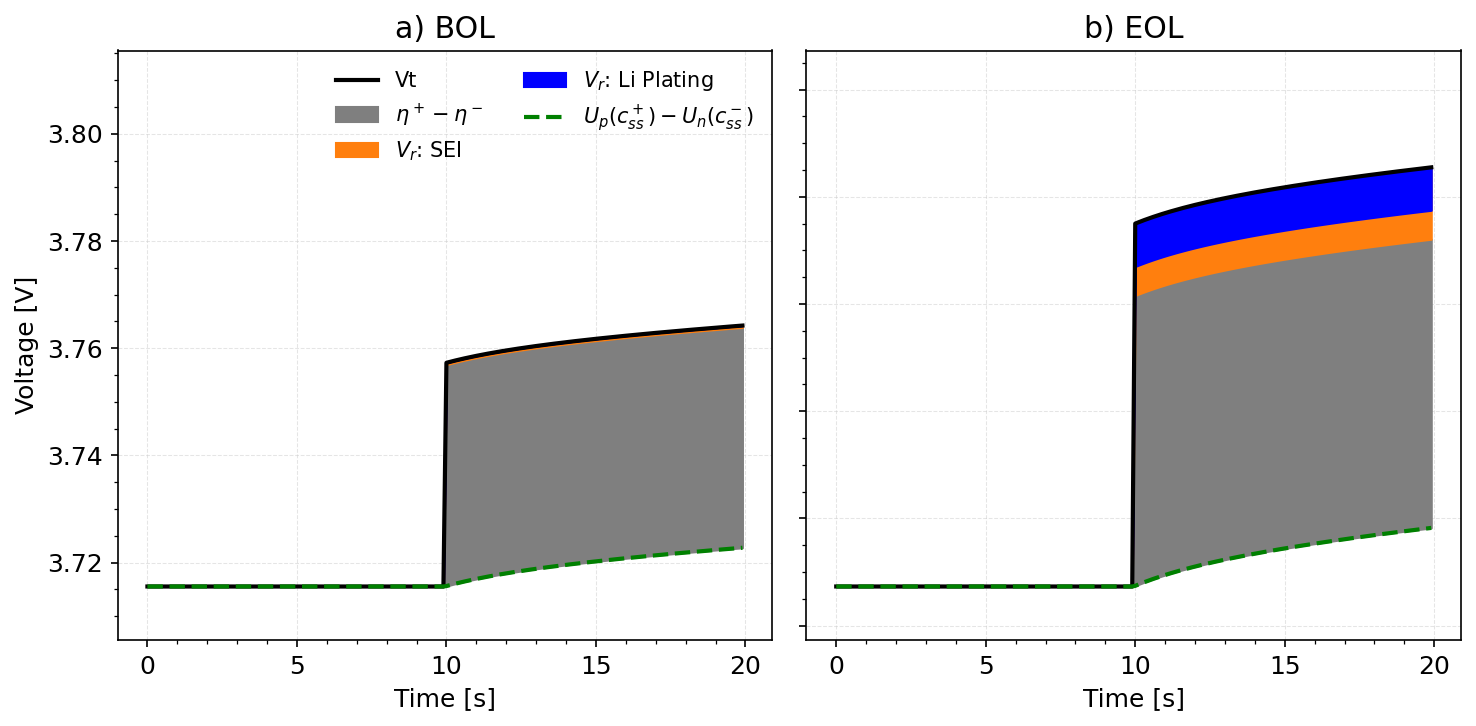

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

In [35]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax1 = ax.flat[0]
ax1.plot(t1,Vt1,'k')
ax1.fill_between(t1, ocv_p1-ocv_n1, ocv_p1+eta_p1-ocv_n1-eta_n1,color='tab:gray')
ax1.fill_between(t1,ocv_p1+eta_p1-ocv_n1-eta_n1,Vt1,color='tab:orange')
ax1.fill_between(t1,ocv_p1+eta_p1-ocv_n1-eta_n1+seif_pot1,Vt1,color='blue')
ax1.plot(t1,ocv_p1-ocv_n1,'g--')
# ax.plot(t,ocv_p+eta_p-ocv_n-eta_n,'r--')
ax1.set_ylim([min(Vt1)-0.01,min(Vt1)+0.1])
ax1.legend(["Vt",r'$\eta^+-\eta^-$',r'$V_r$: SEI',r'$V_r$: Li Plating',r"$U_p(c^+_{ss})-U_n(c^-_{ss})$"],ncol=2)
# ax.legend(["Vt",r'$\eta^+-\eta^-$',r'$V_r$: SEI',r"$U_p(c^+_{ss})-U_n(c^-_{ss})$"])
# ax.text(0.75,0.5,r'$\eta^+-\eta^-$',transform=ax.transAxes,fontsize=14)
# ax.text(0.75,0.78,r'$V_r$',transform=ax.transAxes,fontsize=14)
ax1.set_title("a) BOL")
ax1.set_ylabel("Voltage [V]")
ax2 = ax.flat[1]
ax2.plot(t2,Vt2,'k')
ax2.fill_between(t2, ocv_p2-ocv_n2, ocv_p2+eta_p2-ocv_n2-eta_n2,color='tab:gray')
ax2.fill_between(t2,ocv_p2+eta_p2-ocv_n2-eta_n2,Vt2,color='tab:orange')
ax2.fill_between(t2,ocv_p2+eta_p2-ocv_n2-eta_n2+seif_pot2,Vt2,color='blue')
ax2.plot(t2,ocv_p2-ocv_n2,'g--')
ax2.set_ylim([min(Vt2)-0.01,min(Vt2)+0.1])
ax2.set_title("b) EOL")
ax2.yaxis.set_tick_params(labelleft=False)
ax1.set_xlabel("Time [s]")
ax2.set_xlabel("Time [s]")
fig.tight_layout()
# ax.set_xlim(left=2296)
plt.savefig(fig_DIR +'lithium_plating_resistance.png')